In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('.\ptsne'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from ptsne.ptsne import ParametricTSNE

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [4]:
mnist_loader = DataLoader(
    MNIST(
        './data',
        train=True,
        download=True,
        transform=ToTensor()
    ),
    batch_size=128,
    shuffle=False,
    num_workers=1,
    pin_memory=True
    )

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as functional

In [6]:
class NNWithDropout(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, p=0.0, use_cuda=False):
        super().__init__()
        self.p = p
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
                
        if use_cuda:
            self.cuda()
            
        self.use_cuda = use_cuda
        
    def forward(self, x):
        output = self.fc1(x)
        output = functional.relu(functional.dropout(output, p=self.p, training=True))
        output = self.out(output)
        return output

    
    def save(self, filename):
        torch.save(self.state_dict(), filename)


    def load(self, filename):
        self.load_state_dict(torch.load(filename))


    def train(self, dataloader, num_epochs=15, optimizer=torch.optim.SGD,
              learning_rate=0.01, loss_function=nn.CrossEntropyLoss(),
              print_time=False, print_loss=True, output_epoch_data=False):


        start_time = time.time()
        batch_step = len(dataloader) // 15

        optimizer = optimizer(self.parameters(), lr=learning_rate)
        criterion = loss_function
        
        epoch_data = []

        for epoch in range(num_epochs):
            running_loss = 0
            curr_epoch = []
            for batch, data in enumerate(dataloader):
                features, targets = data
                features = features.view(-1, self.input_dim)

                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                
                optimizer.zero_grad()

                outputs = self(features)
                
                if output_epoch_data:
                    curr_epoch.append(outputs)
                
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if print_loss and batch % batch_step == 0:
                    print('.', end='')
                    
            epoch_data.append(torch.cat(curr_epoch))

            if print_loss:
                print('\nEpoch {}\tLoss: {}'.format(epoch, running_loss))

            if print_time:
                print('Time taken since start: {} s'.format(
                    time.time()-start_time))
    
        if print_loss:
            print(('=' * 10) + '\nTraining done!')
            
        if output_epoch_data:
            return torch.stack(epoch_data)

    
    def predict(self, x, num_samples):
        
        with torch.no_grad():
            features = x
            if self.use_cuda:
                features = features.cuda()
            
            outputs = [self.forward(features.view(-1, self.input_dim)) for _ in range(num_samples)]
        
        return torch.stack(outputs)


    def predict_all(self, dataloader, num_samples):

        with torch.no_grad():

            outputs = []
            for batch, data in enumerate(dataloader):

                print('Predicting batch {} of {}'.format(
                    batch, len(dataloader)
                ), end='\r', flush=True)

                features, targets = data

                if self.use_cuda:
                    features = features.cuda()

                predictions = [self.forward(features.view(-1, self.input_dim)) for _ in range(num_samples)]
                predictions = torch.stack(predictions)
                predictions = predictions.transpose(0,1)

                outputs.append(predictions)
        
        return torch.cat(outputs)

In [27]:
net = NNWithDropout(28*28, 500, 10, use_cuda=True)

In [28]:
foo = net.train(mnist_loader, output_epoch_data=True, learning_rate=0.1)

................
Epoch 0	Loss: 259.8376734852791
................
Epoch 1	Loss: 131.2264892682433
................
Epoch 2	Loss: 105.77301885932684
................
Epoch 3	Loss: 88.7236807718873
................
Epoch 4	Loss: 76.2609777636826
................
Epoch 5	Loss: 66.75113126449287
................
Epoch 6	Loss: 59.272770058363676
................
Epoch 7	Loss: 53.23478744737804
................
Epoch 8	Loss: 48.24756599962711
................
Epoch 9	Loss: 44.03791152872145
................
Epoch 10	Loss: 40.43339549563825
................
Epoch 11	Loss: 37.30996600724757
................
Epoch 12	Loss: 34.58373643644154
................
Epoch 13	Loss: 32.166241094470024
................
Epoch 14	Loss: 30.030753672122955
Training done!


In [29]:
outdata = net.predict_all(mnist_loader, 1)

In [30]:
outdata = outdata.reshape(60000,10).cpu()

In [35]:
p_precalc = tsne.p_ij

In [36]:
tsne = ParametricTSNE(10, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)

In [37]:
tsne.fit(outdata[:20000], batch_size=100, p_ij=p_precalc, epochs=30, learning_rate=0.01, pretrain=True, verbose=True, loss_func='kl')

Calculating PCA
2020-01-15 14:45:26.367668: Beginning pretraining for 5 epochs
2020-01-15 14:45:27.344584: Loss after epoch 0: 191.86349151143804
2020-01-15 14:45:28.273864: Loss after epoch 1: 1.5376524834427983
2020-01-15 14:45:29.222027: Loss after epoch 2: 1.0620354597922415
2020-01-15 14:45:30.141301: Loss after epoch 3: 2.2288057962432504
2020-01-15 14:45:31.070458: Loss after epoch 4: 4.990302415098995
2020-01-15 14:45:31.070458: Finished pretraining
2020-01-15 14:45:31.070458: Beginning training for 30 epochs
2020-01-15 14:45:32.796151: Loss after epoch 1: 647.9751039349936
2020-01-15 14:45:34.520103: Loss after epoch 2: 619.2599008271422
2020-01-15 14:45:36.359534: Loss after epoch 3: 620.4232813187054
2020-01-15 14:45:38.094741: Loss after epoch 4: 593.1073653136648
2020-01-15 14:45:39.856713: Loss after epoch 5: 609.54066552343
2020-01-15 14:45:41.566759: Loss after epoch 6: 593.5624259676214
2020-01-15 14:45:43.291781: Loss after epoch 7: 584.345929468079
2020-01-15 14:45:4

In [38]:
bar = tsne.forward(outdata[:20000].cuda()).cpu().detach()

In [2]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

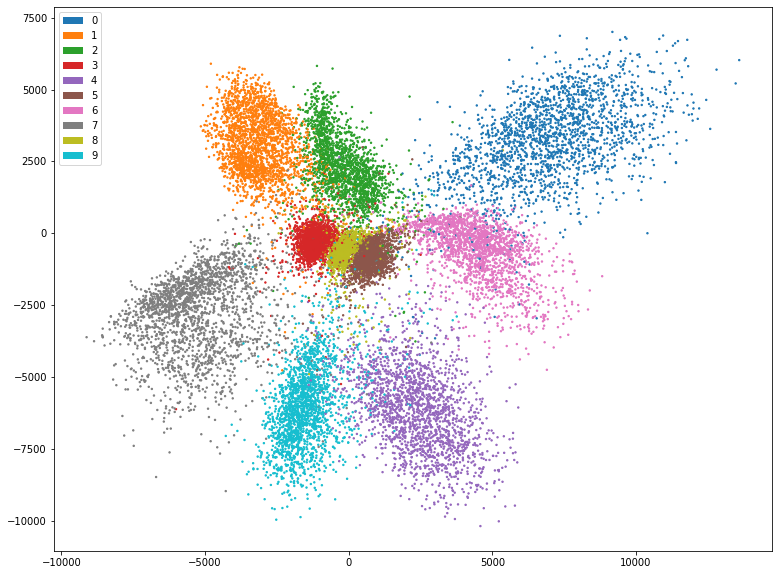

In [40]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in MNIST('./data',train=True,
        download=True,transform=ToTensor()
    ).targets[:20000]]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [63]:
baz = tsne.forward(foo.reshape(-1,10).cuda())

In [65]:
pro_data = baz.reshape(15,-1,2).cpu().detach()

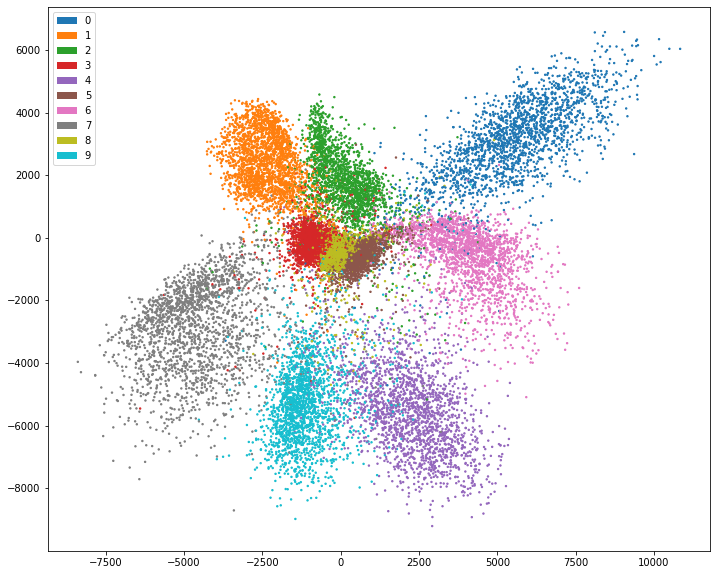

In [69]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in MNIST('./data',train=True,
        download=True,transform=ToTensor()
    ).targets[:20000]]
ax.scatter(pro_data[5,:20000,0],pro_data[5,:20000,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

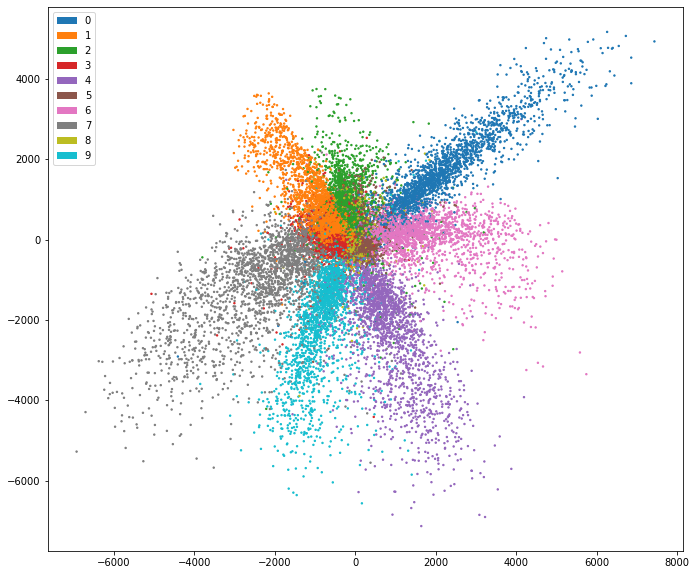

In [73]:
bazoo = (pro_data[1] - pro_data[0])[:20000]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in MNIST('./data',train=True,
        download=True,transform=ToTensor()
    ).targets[:20000]]
ax.scatter(bazoo[:,0],bazoo[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

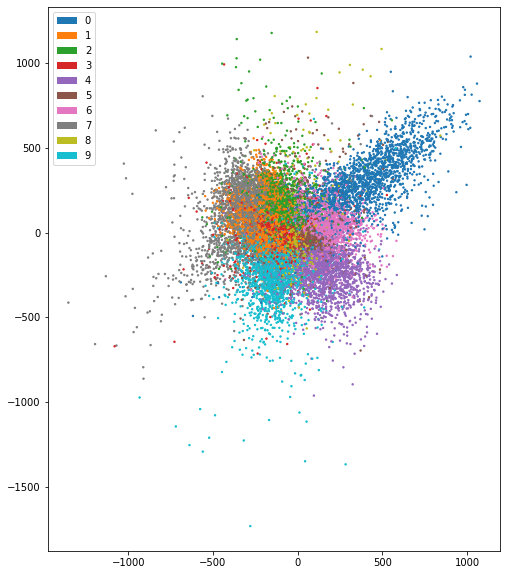

In [74]:
bazoo = (pro_data[2] - pro_data[1])[:20000]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in MNIST('./data',train=True,
        download=True,transform=ToTensor()
    ).targets[:20000]]
ax.scatter(bazoo[:,0],bazoo[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [82]:
np.savetxt('projected_output_test_last.csv', bar.numpy())

In [4]:
from scipy import interpolate

In [3]:
coords = np.loadtxt('projected_output_test.csv')

In [9]:
coords = coords.reshape(15, 60000, 2)

In [7]:
def rescale(x, minmax, y_minmax):
    a, b = minmax
    c, d = y_minmax
    return (d-c) * x / (b-a) - (a*d - b*c) / (b-a)

In [8]:
def scale(x1, y1, x2, y2):
    
    x1 = rescale(x1, (x2.min(), x2.max()), (-1., 1.))
    x2 = rescale(x2, (x2.min(), x2.max()), (-1., 1.))
    y1 = rescale(y1, (y2.min(), y2.max()), (-1., 1.))
    y2 = rescale(y2, (y2.min(), y2.max()), (-1., 1.))    
    
    return x1, y1, x2, y2

In [9]:
def scale_and_interpolate(x1, y1, x2, y2):
    
    x1, y1, x2, y2 = scale(x1, y1, x2, y2)
    
    xx = np.linspace(-1, 1, 200)
    yy = np.linspace(-1, 1, 200)
    xx, yy = np.meshgrid(xx, yy)

    points = np.transpose(np.vstack((x1, y2)))
    u = interpolate.griddata(points, x2-x1, (xx, yy), method='nearest')
    v = interpolate.griddata(points, y2-y1, (xx, yy), method='nearest')
    
    return xx, yy, u, v

In [10]:
def total_divergence(x1, y1, x2, y2):
    
    x, y, u, v = scale_and_interpolate(x1, y1, x2, y2)
    num_points = x.shape[0] * x.shape[1]
        
    return (np.gradient(u, 0.01, axis=1) + np.gradient(v, 0.01, axis=0)).sum() / num_points

In [46]:
def outward_flow(x1, y1, x2, y2, interpolate=False):
    if interpolate:
        x, y, u, v = scale_and_interpolate(x1, y1, x2, y2)
        num_points = x.shape[0] * x.shape[1]
    else:
        x, y, x2, y2 = scale(x1, y1, x2, y2)
        u = x2 - x
        v = y2 - y
        num_points = x.shape[0]
        
    coord_norms = np.sqrt(x**2 + y**2)
    # flow_norms = np.sqrt(u**2 + v**2)
    inner_product = x*u + y*v
    
    return (inner_product / coord_norms).sum() / num_points
    
    # angles = np.arccos( inner_product / (coord_norms*flow_norms) ) / np.pi
    # return (angles*flow_norms).sum() / num_points

In [47]:
def rescale_torch(x, xmin, xmax, new_xmin=-1., new_xmax=1.):
    a, b = xmin, xmax
    c, d = new_xmin, new_xmax
    return (d-c) * x / (b-a) - (a*d - b*c) / (b-a)

def scale_torch(out_ep1, out_ep2, x_range=[-1.,1.], y_range=[-1.,1.]):
    
    all_data = torch.cat([out_ep1, out_ep2])    
    x_min, y_min = all_data.min(dim=0).values
    x_max, y_max = all_data.max(dim=0).values
    
    scaledx1 = rescale_torch(out_ep1[:,0], x_min, x_max, new_xmin=x_range[0], new_xmax=x_range[1])
    scaledx2 = rescale_torch(out_ep2[:,0], x_min, x_max, new_xmin=x_range[0], new_xmax=x_range[1])
    scaledy1 = rescale_torch(out_ep1[:,1], y_min, y_max, new_xmin=y_range[0], new_xmax=y_range[1])
    scaledy2 = rescale_torch(out_ep2[:,1], y_min, y_max, new_xmin=y_range[0], new_xmax=y_range[1])
    
    return torch.stack((scaledx1, scaledy1)).t(), torch.stack((scaledx2, scaledy2)).t()

def outward_flow_torch(out_ep1, out_ep2, x_range=[-1.,1.], y_range=[-1.,1.]):
    
    ep1, ep2 = scale_torch(out_ep1, out_ep2, x_range=[-1.,1.], y_range=[-1.,1.])
    num_points = ep1.shape[0]
    
    x = ep1
    flow = ep2 - ep1
    x_norms = x.norm(dim=1)
    # flow_norms = flow.norm(dim=1)
    inner = (x * flow).sum(dim=1)
    
    return (inner / x_norms).sum() / num_points
    
    # angles = torch.acos(inner / (x_norms*flow_norms)) / np.pi
    # return (angles * flow_norms).sum() / num_points

In [49]:
a = torch.tensor(coords[0])
b = torch.tensor(coords[1], requires_grad=True)

foo = outward_flow_torch(a, b)

In [50]:
foo.backward()

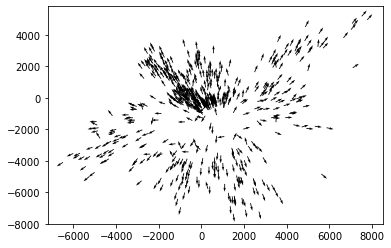

In [88]:
bar = b.grad.detach().numpy()
baz = b.detach().numpy()
plt.quiver(baz[::100,0], baz[::100,1], bar[::100,0], bar[::100,1])

In [82]:
bar = (1e10 * b.grad).detach()

In [26]:
outward_flow(coords[0,:,0], coords[0,:,1], coords[1,:,0], coords[1,:,1], interpolate=False)

4321.774617494623

In [17]:
def total_divergence_over_time(dataset):
    div = []
    for i, j in zip(dataset[:-1], dataset[1:]):
        div.append(total_divergence(i[:,0], i[:,1], j[:,0], j[:,1]))
    return np.array(div)

In [18]:
def outward_flow_over_time(dataset, interpolate=False):
    flow = []
    for i, j in zip(dataset[:-1], dataset[1:]):
        flow.append(outward_flow(i[:,0], i[:,1], j[:,0], j[:,1], interpolate=interpolate))
    return np.array(flow)

In [19]:
div = total_divergence_over_time(coords)

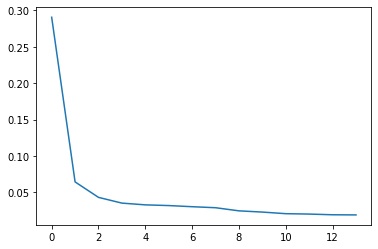

In [20]:
plt.plot(div)

In [42]:
flow = outward_flow_over_time(coords, interpolate=False)

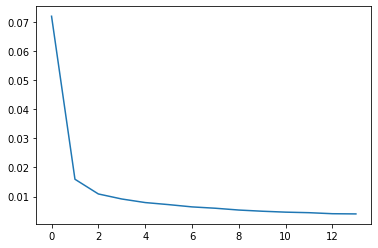

In [43]:
plt.plot(flow)

In [44]:
flow_int = outward_flow_over_time(coords, interpolate=True)

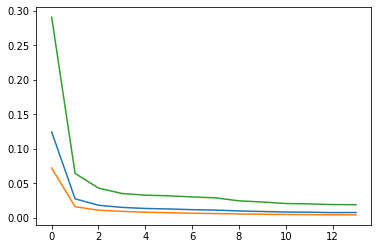

In [45]:
plt.plot(flow_int)
plt.plot(flow)
plt.plot(div)

In [193]:
x1 = coords[0,:,0]
x2 = coords[1,:,0]
y1 = coords[0,:,1]
y2 = coords[1,:,1]
x1 = rescale(x1, (x2.min(), x2.max()), (-1., 1.))
x2 = rescale(x2, (x2.min(), x2.max()), (-1., 1.))
y1 = rescale(y1, (y2.min(), y2.max()), (-1., 1.))
y2 = rescale(y2, (y2.min(), y2.max()), (-1., 1.))

xx = np.linspace(-1, 1, 200)
yy = np.linspace(-1, 1, 200)
xx, yy = np.meshgrid(xx, yy)

points = np.transpose(np.vstack((x1, y2)))
u_interp = interpolate.griddata(points, x2-x1, (xx, yy), method='nearest')
v_interp = interpolate.griddata(points, y2-y1, (xx, yy), method='nearest')

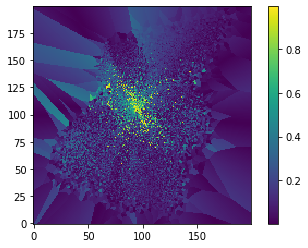

In [211]:
plt.imshow(np.arccos((xx * u_interp + yy * v_interp) / (np.sqrt(xx**2 + yy**2) * np.sqrt(u_interp**2 + v_interp**2)) ) / np.pi, origin='lower')
plt.colorbar()

In [220]:
hist, binb = np.histogram(np.arccos((xx * u_interp + yy * v_interp) / (np.sqrt(xx**2 + yy**2) * np.sqrt(u_interp**2 + v_interp**2)) ) / np.pi, 100)

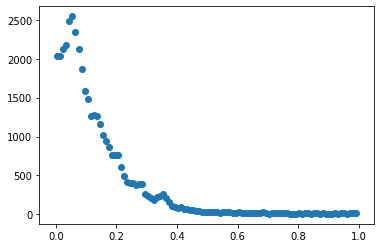

In [224]:
plt.scatter((binb[:-1] + binb[1:])/2, hist)

In [225]:
(np.arccos((xx * u_interp + yy * v_interp) / (np.sqrt(xx**2 + yy**2) * np.sqrt(u_interp**2 + v_interp**2)) ) / np.pi).sum()

5190.669082485221

In [258]:
total_divergence(coords[0,:,0], coords[0,:,1], coords[1,:,0], coords[1,:,1])

0.29069000326575284

In [44]:
def rescale_torch(x, xmin, xmax, new_xmin=-1., new_xmax=1.):
    a, b = xmin, xmax
    c, d = new_xmin, new_xmax
    return (d-c) * x / (b-a) - (a*d - b*c) / (b-a)

def scale_torch(out_ep1, out_ep2, x_range=[-1.,1.], y_range=[-1.,1.]):
    
    all_data = torch.cat([out_ep1, out_ep2])    
    x_min, y_min = all_data.min(dim=0).values
    x_max, y_max = all_data.max(dim=0).values
    
    scaledx1 = rescale_torch(out_ep1[:,0], x_min, x_max, new_xmin=x_range[0], new_xmax=x_range[1])
    scaledx2 = rescale_torch(out_ep2[:,0], x_min, x_max, new_xmin=x_range[0], new_xmax=x_range[1])
    scaledy1 = rescale_torch(out_ep1[:,1], y_min, y_max, new_xmin=y_range[0], new_xmax=y_range[1])
    scaledy2 = rescale_torch(out_ep2[:,1], y_min, y_max, new_xmin=y_range[0], new_xmax=y_range[1])
    
    return torch.stack((scaledx1, scaledy1)).t(), torch.stack((scaledx2, scaledy2)).t()

def sparse_vector_field(out_ep1, out_ep2, x_grid_dim=200, y_grid_dim=200):
    
    x_min, y_min = out_ep1.min(dim=0).values
    x_max, y_max = out_ep1.max(dim=0).values
    coords = torch.stack((
        rescale_torch(out_ep1[:,0], x_min, x_max, new_xmin=0, new_xmax=x_grid_dim-1),
        rescale_torch(out_ep1[:,1], y_min, y_max, new_xmin=0, new_xmax=y_grid_dim-1)
    )).t()
    
    #ep1, ep2 = scale_torch(out_ep1, out_ep2, x_range=[0,x_grid_dim-1], y_range=[0,y_grid_dim-1])

    flow = out_ep2 - out_ep1
    
    indices = coords.round().long()
    _, count_indices, counts = np.unique(indices, axis=0, return_inverse=True, return_counts=True)
    counts = torch.tensor(counts[count_indices]).unsqueeze(1)
    
    field = torch.sparse.FloatTensor(indices.t(), flow/counts , torch.Size([x_grid_dim, y_grid_dim, 2]))
    
    return field.coalesce()

def sparse_total_divergence(out_ep1, out_ep2, x_grid_dim=200, y_grid_dim=200):
    
    field = sparse_vector_field(out_ep1, out_ep2, x_grid_dim=x_grid_dim, y_grid_dim=y_grid_dim)
    field = field.to_dense()
    
    rows_most = field[:,:-1,0]
    rows_rest = field[:,1:,0]
    cols_most = field[:-1,:,1]
    cols_rest = field[1:,:,1]
    
    field_dx = rows_rest - rows_most
    field_dy = cols_rest - cols_most
    
    return field_dx.sum() + field_dy.sum()
    
    x_mask = (rows_most*rows_rest).bool().int()
    y_mask = (cols_most*cols_rest).bool().int()
    
    div = (field_dx * x_mask).sum() + (field_dy * y_mask).sum()
    
    return div

In [41]:
def sparse_divergence_over_time(dataset, grid_dim=100):
    div = []
    for i, j in zip(dataset[:-1], dataset[1:]):
        div.append(sparse_total_divergence(i, j, x_grid_dim=grid_dim, y_grid_dim=grid_dim))
    return np.array(div)

In [160]:
foo = sparse_vector_field(torch.tensor(coords[1]), torch.tensor(coords[2]))

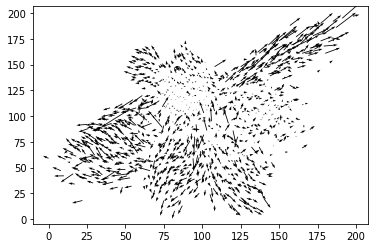

In [161]:
a, b = foo.indices()
c, d = foo.values().t()
plt.quiver(a[::13],b[::13],c[::13],d[::13])

In [55]:
divs = sparse_divergence_over_time(torch.tensor(coords), grid_dim=20)

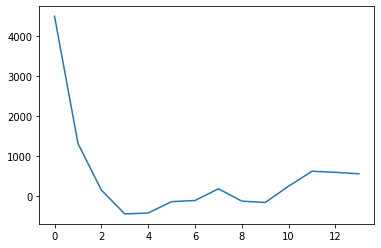

In [56]:
plt.plot(divs)

In [10]:
torch.tensor(coords)

tensor([[[  360.6267,  -492.8416],
         [  403.7782,  -475.3271],
         [  445.3735,  -558.6569],
         ...,
         [  143.1940,  -840.4604],
         [ 2912.7275,  -811.7965],
         [  667.0052,    19.9847]],

        [[  100.1947,  -398.9478],
         [ 5882.9766,  3683.1755],
         [  995.7589, -3312.0442],
         ...,
         [  192.4018,  -878.2177],
         [ 2949.0278,  -858.5427],
         [  677.6292,   -25.1911]],

        [[  223.2237,  -494.9093],
         [ 5975.4951,  3884.4192],
         [  949.5219, -3149.8337],
         ...,
         [  235.8380,  -906.2869],
         [ 2969.1843,  -936.0480],
         [  615.5911,  -102.2277]],

        ...,

        [[  109.1909,  -638.6416],
         [ 6791.9375,  4554.8320],
         [ 1306.3799, -3263.1982],
         ...,
         [  517.3445, -1149.0664],
         [ 3168.1799, -1040.3308],
         [  166.3638,  -505.9928]],

        [[   95.0888,  -665.1045],
         [ 6926.3052,  4615.2251],
         [ 1